<a href="https://colab.research.google.com/github/RobWamsley/Quantum-Rings-Colab/blob/main/05_Grover's_Algorithm_%7C_Quantum_Rings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grover’s Search Algorithm
In 1996 Lov Grover introduced a novel search algorithm which exhibits quadratic speedup and uses a technique called amplitude amplification. Imagine that we are given a printed phone book and asked to find to whom a particular phone number is associated. Phone directories are usually arranged alpabetically. We have to go through each entry in the phone directory to determine whom the phone number belongs.

This Sample code implements Grovers, following the explination in the Quantum Rings Documentation on Grover's Algorithm here:
https://www.quantumrings.com/doc/Grovers.html

In [ ]:
!pip install QuantumRingsLib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.6 MB/s eta 0:00:00


In [ ]:
import QuantumRingsLib
from QuantumRingsLib import QuantumRegister, AncillaRegister, ClassicalRegister, QuantumCircuit
from QuantumRingsLib import QuantumRingsProvider
from QuantumRingsLib import job_monitor
from QuantumRingsLib import JobStatus
from QuantumRingsLib import qasm2
from QuantumRingsLib import OptimizeQuantumCircuit
from matplotlib import pyplot as plt
import numpy as np
import math
import time

In [5]:
from google.colab import userdata
email = userdata.get('api_email')
key = userdata.get('api_key')

provider = QuantumRingsProvider(token=key, name=email)
backend = provider.get_backend("scarlet_quantum_rings")

acct = provider.active_account()

In [6]:
def ccz(qc, control1, control2, target):
    """
    The CCZ gate or the doubly controlled Z-gate.
    This gate flips the phase of the target qubit if the control qubits are in |11> state.

    Args:
         qc (QuantumCircuit):
            The quantum Circuit to use.

        control1 (int):
            The index number of the first control qubit.

        control2 (int):
            The index number of the second control qubit.

        target (int):
            The index number of the target qubit, where the transform is applied

    Returns:
        None


    """
    qc.h(target)
    qc.ccx(control1, control2, target)
    qc.h(target)
    return


def cccx(qc,control1, control2, control3, anc, target):
    """
    The three control Toffoli gate.
    An X gate is applied to the target qubit, if the control qubits are in state |111>.

    Args:
        qc (QuantumCircuit):
            The quantum Circuit to use.

        control1 (int):
            The index number of the first control qubit.

        control2 (int):
            The index number of the second control qubit.

        control3 (int):
            The index number of the third control qubit

        anc (int):
            The index number of a temporary worker qubit

        target (int):
            The index number of the target qubit, where the transform is applied

    Returns:
        None
    """
    qc.ccx(control1, control2, anc)
    qc.ccx(control3, anc, target)
    qc.ccx(control1, control2, anc)
    qc.ccx(control3, anc, target)
    return



def grover_oracle( qc, x0, x1, x2, anc, y):
    """
    The Grover's Oracle

    Args:
        qc (QuantumCircuit):
            The quantum Circuit to use.

        x0 (int):
            The index number of the first qubit of the x register.

        x1 (int):
            The index number of the second qubit of the x register.

        x2 (int):
            The index number of the third qubit of the x register.

        anc (int):
            The index number of a temporary work qubit

        y (int):
            The index number of the target qubit, where the transform is applied

    Returns:
        None.

    """
    qc.x(x2)
    qc.x(x0)
    cccx(qc, x0, x1, x2, anc, y)
    qc.x(x0)
    qc.x(x2)



def grover_diffusion_operator(qc, x0, x1, x2, y):
    """
    The 3-qubit diffusion operator for Grover's algorith.

    Args:
        x0 (int):
            The index number of the first qubit of the x register.

        x1 (int):
            The index number of the second qubit of the x register.

        x2 (int):
            The index number of the third qubit of the x register.

        y (int):
            The index number of the target qubit, where the transform is applied

    Returns:
        None.


    """

    qc.h(x0)
    qc.h(x1)
    qc.h(x2)
    qc.h(y) # Bring this back to state 1 for next stages
    qc.x(x0)
    qc.x(x1)
    qc.x(x2)
    ccz(qc, x0, x1, x2 )
    qc.x(x0)
    qc.x(x1)
    qc.x(x2)
    qc.h(x0)
    qc.h(x1)
    qc.h(x2)



def plot_histogram (counts, title=""):
    """
    Plots the histogram of the counts

    Args:

        counts (dict):
            The dictionary containing the counts of states

        titles (str):
            A title for the graph.

    Returns:
        None

    """
    fig, ax = plt.subplots(figsize =(10, 7))
    plt.xlabel("States")
    plt.ylabel("Counts")
    mylist = [key for key, val in counts.items() for _ in range(val)]

    unique, inverse = np.unique(mylist, return_inverse=True)
    bin_counts = np.bincount(inverse)

    plt.bar(unique, bin_counts)

    maxFreq = max(counts.values())
    plt.ylim(ymax=np.ceil(maxFreq / 10) * 10 if maxFreq % 10 else maxFreq + 10)
    # Show plot
    plt.title(title)
    plt.show()
    return


### Execute the circuit

Note that I'm only running 1 "shot", again, because this is on free compute, but normally you would run thousands of shots.

Job Running
Job Done.
Ending Job Monitor
{'010': 100}


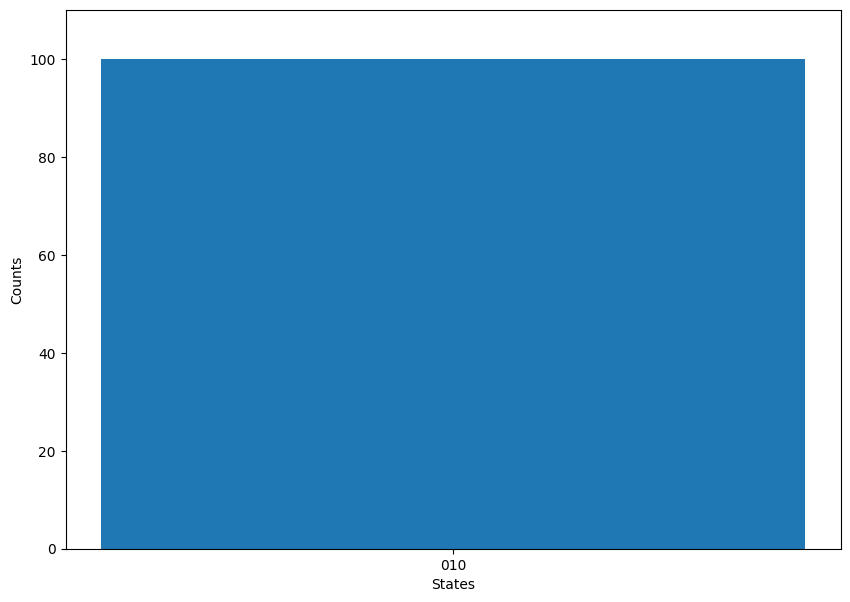

In [7]:

shots = 100

#
# Grover's algorithm
#
q = QuantumRegister(3 , 'x')
y = QuantumRegister(1 , 'y')
anc = QuantumRegister(1 , 'a')
c = ClassicalRegister(3 , 'c')
qc = QuantumCircuit(q, y, anc, c)

qc.x(y[0])
qc.h(q[0])
qc.h(q[1])
qc.h(q[2])
qc.h(y[0])

grover_oracle (qc, q[0], q[1], q[2], anc[0], y[0])
grover_diffusion_operator (qc, q[0], q[1], q[2], y[0])

grover_oracle (qc, q[0], q[1], q[2], anc[0], y[0])
grover_diffusion_operator (qc, q[0], q[1], q[2], y[0])

grover_oracle (qc, q[0], q[1], q[2], anc[0], y[0])
grover_diffusion_operator (qc, q[0], q[1], q[2], y[0])

qc.measure(q[0],c[0])
qc.measure(q[1],c[1])
qc.measure(q[2],c[2])

job = backend.run(qc, shots)
job_monitor(job)
result = job.result()
counts = result.get_counts()
print (counts)

del q, y, anc
del c
del qc
del result
del job

plot_histogram(counts, "")